In [1]:
import sys
sys.path.insert(0, '/Users/xiaohan/Working/Ning/Giles1/Code/Python_Implementation/scripts')

from empirical_cdf import empirical_rf_pdf
from eif import eif_cpi_empirical
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np




N = 500
seed = 2024
np.random.seed(2024)

# Read the data with column names
bikeshare_data = pd.read_csv(
    '/Users/xiaohan/Working/Ning/Giles1/Code/Python_Implementation/data/day.csv')
seed = 2024
np.random.seed(seed)

df = bikeshare_data
# Drop the 'instant' and 'dteday' columns
df.drop(['instant', 'dteday'], axis=1, inplace=True)

# Move the 'cnt' column to the first position
cnt = df.pop('cnt')
df.insert(0, 'cnt', cnt)

bikeshare_data = df
full_data = bikeshare_data.copy()

# Get all feature columns (excluding the target 'cnt')
feature_columns = [col for col in full_data.columns if col != 'cnt']
print(f"Features to analyze: {feature_columns}")

# Dictionary to store results for each feature
results = {}

# Loop through each feature
for feature_name in feature_columns:
    print(f"\n{'='*50}")
    print(f"Analyzing feature: {feature_name}")
    print(f"{'='*50}")

    # Create reduced data by dropping the current feature
    reduced_data = full_data.drop([feature_name], axis=1, inplace=False)

    # Use the seed defined earlier
    np.random.seed(2024)

    # Fit full model using XGBoost
    full_model = XGBRegressor(n_estimators=500, random_state=seed)
    full_model.fit(full_data.iloc[:, 1:], full_data["cnt"])

    # Fit reduced model using XGBoost
    reduced_model = XGBRegressor(n_estimators=500, random_state=seed)
    reduced_model.fit(reduced_data.iloc[:, 1:], reduced_data["cnt"])

    # Fit random forest model for Y (outcome)
    reduced_model_y = RandomForestRegressor(
        n_estimators=500, max_features=1/3, random_state=seed)
    reduced_model_y.fit(reduced_data.iloc[:, 1:], reduced_data["cnt"])

    # Fit random forest model for X (the feature being analyzed)
    reduced_model_x = RandomForestRegressor(
        n_estimators=500, max_features=1/3, random_state=seed)
    X_features_for_x_model = full_data.drop(
        ["cnt", feature_name], axis=1, inplace=False)
    reduced_model_x.fit(X_features_for_x_model, full_data[feature_name])

    # Empirical densities
    reduced_den_y = empirical_rf_pdf(forest=reduced_model_y,
                                     X_train=reduced_data.iloc[:, 1:],
                                     X_test=reduced_data.iloc[:, 1:],
                                     seed=seed+2024)

    reduced_den_x = empirical_rf_pdf(forest=reduced_model_x,
                                     X_train=X_features_for_x_model,
                                     X_test=X_features_for_x_model,
                                     seed=seed+2024)

    # Calculate EIF
    eif_now = eif_cpi_empirical(
        full_data, reduced_den_y, reduced_den_x, N, full_model, seed+2024)

    # Calculate CPI metrics
    naive_CPI = np.mean(eif_now.iloc[:, 2])
    plug_in_CPI = np.mean(
        eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2])

    # Calculate EIF
    eif = eif_now.iloc[:, 0] - 2 * eif_now.iloc[:, 1] + eif_now.iloc[:, 2]

    # Prepare regress_frame
    curr_offset = reduced_model.predict(X_features_for_x_model)
    regress_frame = pd.DataFrame({
        'y': full_data.iloc[:, 0],
        'curr_offset': curr_offset,
        'obs': eif
    })

    # Perform linear regression
    lm = LinearRegression(fit_intercept=False)
    lm.fit(regress_frame[['curr_offset', 'obs']], regress_frame['y'])
    epsilon_now = lm.coef_[1]
    next_offset = lm.predict(regress_frame[['curr_offset', 'obs']])

    # Update densities
    eif_scaled = eif * epsilon_now/100
    reduced_den_x_update = reduced_den_x + \
        np.outer(eif_scaled, np.ones(reduced_den_x.shape[1]))
    reduced_den_x_update = np.maximum(reduced_den_x_update, 0)
    row_sums = reduced_den_x_update.sum(axis=1, keepdims=True)
    reduced_den_x_update = np.divide(
        reduced_den_x_update, row_sums, where=row_sums != 0)

    reduced_den_y_update = reduced_den_y + \
        np.outer(eif_scaled, np.ones(reduced_den_y.shape[1]))
    reduced_den_y_update = np.maximum(reduced_den_y_update, 0)
    row_sums = reduced_den_y_update.sum(axis=1, keepdims=True)
    reduced_den_y_update = np.divide(
        reduced_den_y_update, row_sums, where=row_sums != 0)

    # Check for normalization issues
    sums = reduced_den_y_update.sum(axis=1)
    non_one_indices = np.where(np.abs(sums - 1) > 1e-10)[0]
    if len(non_one_indices) > 0:
        print(
            f"Warning: {len(non_one_indices)} rows don't sum to 1 for feature {feature_name}")

    # Recalculate EIF
    eif_now = eif_cpi_empirical(
        full_data, reduced_den_y_update, reduced_den_x_update, N, full_model, 2024)
    tmle_onestep = np.mean(
        eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2])

    # Iterative process for TMLE
    tol = 1e-3
    epsilon = 1
    iteration_count = 0
    max_iterations = 100

    while epsilon > tol and iteration_count < max_iterations:
        iteration_count += 1
        eif = eif_now.iloc[:, 0] - 2 * eif_now.iloc[:, 1] + eif_now.iloc[:, 2]
        regress_frame['obs'] = eif
        regress_frame['curr_offset'] = next_offset

        lm.fit(regress_frame[['curr_offset', 'obs']], regress_frame['y'])
        epsilon_now = lm.coef_[1]
        next_offset = lm.predict(regress_frame[['curr_offset', 'obs']])

        eif_scaled = eif * epsilon_now/100

        reduced_den_x_update = reduced_den_x + \
            np.outer(eif_scaled, np.ones(reduced_den_x.shape[1]))
        reduced_den_x_update = np.maximum(reduced_den_x_update, 0)
        row_sums = reduced_den_x_update.sum(axis=1, keepdims=True)
        reduced_den_x_update = np.divide(
            reduced_den_x_update, row_sums, where=row_sums != 0)

        reduced_den_y_update = reduced_den_y + \
            np.outer(eif_scaled, np.ones(reduced_den_y.shape[1]))
        reduced_den_y_update = np.maximum(reduced_den_y_update, 0)
        row_sums = reduced_den_y_update.sum(axis=1, keepdims=True)
        reduced_den_y_update = np.divide(
            reduced_den_y_update, row_sums, where=row_sums != 0)

        eif_now = eif_cpi_empirical(
            full_data, reduced_den_y_update, reduced_den_x_update, N, full_model, seed+2024)
        epsilon = abs(epsilon_now)

    if iteration_count >= max_iterations:
        print(
            f"Warning: Maximum iterations ({max_iterations}) reached for feature {feature_name}")

    tmle_final = np.mean(
        eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2])
    tmle_var = np.mean(
        (eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2] - tmle_final)**2)

    # Calculate filtered results (removing extreme values)
    eif_values = eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2]
    p1 = np.percentile(eif_values, 1)
    p99 = np.percentile(eif_values, 99)
    filtered_eif = eif_values[(eif_values >= p1) & (eif_values <= p99)]

    new_tmle_final = np.mean(filtered_eif)
    new_tmle_var = np.mean((filtered_eif - new_tmle_final)**2)

    # Calculate confidence interval
    n_obs = len(full_data)
    ci_margin = 2 * np.sqrt(new_tmle_var / n_obs)

    # Store results
    results[feature_name] = {
        'naive_CPI': naive_CPI,
        'plug_in_CPI': plug_in_CPI,
        'tmle_onestep': tmle_onestep,
        'tmle_final': tmle_final,
        'tmle_var': tmle_var,
        'filtered_tmle_final': new_tmle_final,
        'filtered_tmle_var': new_tmle_var,
        'ci_margin': ci_margin,
        'iterations': iteration_count
    }

    # Print results for this feature
    print(f"Results for {feature_name}:")
    print(f"  Naive CPI: {naive_CPI:.6f}")
    print(f"  Plug-in CPI: {plug_in_CPI:.6f}")
    print(f"  TMLE One-step: {tmle_onestep:.6f}")
    print(f"  TMLE Final: {tmle_final:.6f}")
    print(f"  TMLE Variance: {tmle_var:.6f}")
    print(f"  Filtered TMLE Final: {new_tmle_final:.6f}")
    print(f"  Filtered TMLE Variance: {new_tmle_var:.6f}")
    print(f"  95% CI Margin: ±{ci_margin:.6f}")
    print(f"  Iterations: {iteration_count}")

# Print summary table
print(f"\n{'='*80}")
print("SUMMARY RESULTS FOR ALL FEATURES")
print(f"{'='*80}")

results_df = pd.DataFrame(results).T
results_df = results_df.round(6)

print(results_df.to_string())

# Find the most important features based on absolute CPI values
results_df['abs_filtered_tmle'] = abs(results_df['filtered_tmle_final'])
importance_ranking = results_df.sort_values(
    'abs_filtered_tmle', ascending=False)

print(f"\n{'='*50}")
print("FEATURE IMPORTANCE RANKING (by absolute TMLE CPI):")
print(f"{'='*50}")
for i, (feature, row) in enumerate(importance_ranking.iterrows()):
    print(
        f"{i+1:2d}. {feature:15s}: {row['filtered_tmle_final']:8.6f} (±{row['ci_margin']:8.6f})")


Features to analyze: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']

Analyzing feature: season
Results for season:
  Naive CPI: 119.127131
  Plug-in CPI: 180.010471
  TMLE One-step: 219.250351
  TMLE Final: 180.057765
  TMLE Variance: 5497725.019949
  Filtered TMLE Final: 77.474460
  Filtered TMLE Variance: 294537.574922
  95% CI Margin: ±40.145943
  Iterations: 1

Analyzing feature: yr
Results for yr:
  Naive CPI: 550.863158
  Plug-in CPI: 712.152240
  TMLE One-step: 786.648618
  TMLE Final: 710.172305
  TMLE Variance: 50377739.735502
  Filtered TMLE Final: 248.217225
  Filtered TMLE Variance: 3192932.492677
  95% CI Margin: ±132.180130
  Iterations: 1

Analyzing feature: mnth
Results for mnth:
  Naive CPI: 80.139366
  Plug-in CPI: 70.675644
  TMLE One-step: 63.610511
  TMLE Final: 70.699689
  TMLE Variance: 2405669.804263
  Filtered TMLE Final: 20.986932
  Filtered TMLE Variance: 108116.780188
  

In [11]:
result_sorted.head()

,naive_CPI,plug_in_CPI,tmle_onestep,tmle_final,tmle_var,filtered_tmle_final,filtered_tmle_var,ci_margin,iterations
workingday,827.685812,720.890027,816.934477,729.164665,1.058516e+08,429.465513,7.731417e+06,205.684165,1.0
yr,550.863158,712.152240,786.648618,710.172305,5.037774e+07,248.217225,3.192932e+06,132.180130,1.0
holiday,899.382045,530.476051,604.890863,527.250270,9.248643e+07,441.804990,7.528646e+06,202.969021,1.0
weathersit,508.412637,425.584246,502.744861,427.552448,4.714898e+07,189.149006,2.686078e+06,121.235736,1.0
weekday,451.217393,281.016533,337.426992,281.305539,4.221781e+07,152.702711,2.732841e+06,122.286491,1.0


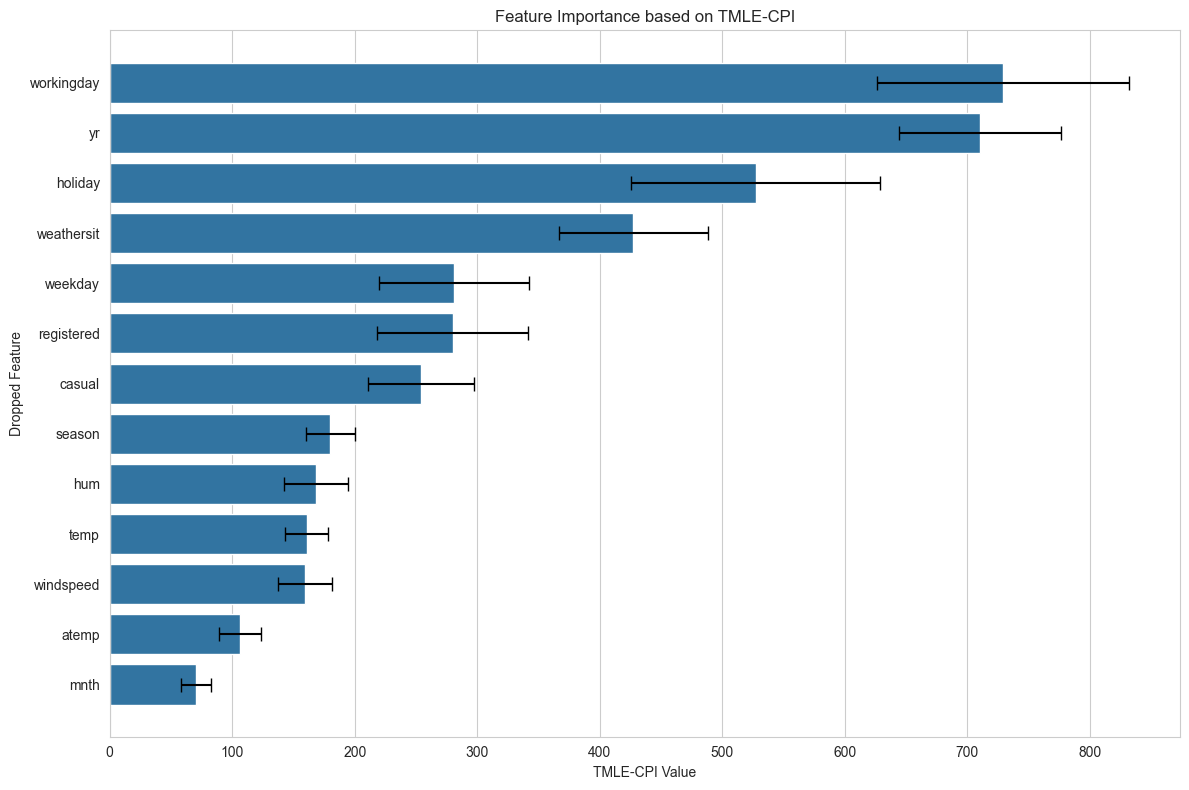

In [ ]:
result_df = pd.DataFrame(results).T
results_sorted = result_df.sort_values(by='tmle_final', ascending=False)
# Plot feature importance based on TMLE
plt.figure(figsize=(12, 8))
sns.barplot(x='tmle_final', y=results_sorted.index, data=results_sorted)
plt.title('Bike Sharing Variable Importance based on TMLE-CPI')
plt.xlabel('TMLE-CPI Value')
plt.ylabel('Dropped Feature')
plt.tight_layout()
# Add error bars to show confidence intervals
plt.errorbar(
    x=results_sorted['tmle_final'],
    y=range(len(results_sorted)),
    xerr=results_sorted['ci_margin']/2,
    fmt='none',
    ecolor='black',
    capsize=5
)
plt.show()